In [1]:
# import json
# import time
# 
# import joblib
# import keras
# import os
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import random
# from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# from glob import glob
%matplotlib inline


# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import tensorflow as tf

# from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-06-12 02:32:15.363124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import os
import shutil
import random

def split_dataset(root_dir, new_root_dir):
    """
    Divise un ensemble de données d'images en ensemble d'entraînement (80%) et de test (20%)
    dans une nouvelle structure de dossiers.

    Args:
        root_dir (str): Chemin vers le dossier racine contenant les sous-dossiers de classes d'images.
        new_root_dir (str): Chemin vers le nouveau dossier racine pour la nouvelle structure de dossiers.
    """
    # Créer les dossiers "train" et "test" dans le nouveau dossier racine
    os.makedirs(os.path.join(new_root_dir, "train"), exist_ok=True)
    os.makedirs(os.path.join(new_root_dir, "val"), exist_ok=True)

    # Parcourir les sous-dossiers dans le dossier racine
    for subfolder in os.listdir(root_dir):
        subfolder_path = os.path.join(root_dir, subfolder)
        if os.path.isdir(subfolder_path):
            # Créer les sous-dossiers "train" et "test" pour chaque classe
            os.makedirs(os.path.join(new_root_dir, "train", subfolder), exist_ok=True)
            os.makedirs(os.path.join(new_root_dir, "val", subfolder), exist_ok=True)

            # Obtenir la liste des fichiers dans le sous-dossier
            files = os.listdir(subfolder_path)
            # Mélanger les fichiers
            random.shuffle(files)

            # Diviser les fichiers en 80% pour l'entraînement et 20% pour le test
            train_files = files[:int(0.8 * len(files))]
            test_files = files[int(0.8 * len(files)):]

            # Copier les fichiers dans les nouveaux dossiers
            for file in train_files:
                shutil.copy(
                    os.path.join(subfolder_path, file),
                    os.path.join(new_root_dir, "train", subfolder, file)
                )
            for file in test_files:
                shutil.copy(
                    os.path.join(subfolder_path, file),
                    os.path.join(new_root_dir, "val", subfolder, file)
                )

In [ ]:
split_dataset("./crowdai", "./crowdai_F")

In [2]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((224, 224))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './crowdai_F'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

### Preparing custom images data for training

In [3]:
train_dir = train_dir

# Load Dataset
train_set = train_dir
test_set = val_dir


### Typical input image size for CNN training is 224x224, 227x227

In [4]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224 
FAST_RUN = False
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [5]:
IM_WIDTH=224
IM_HEIGHT=224
EPOCH=200
batch_size=64
NB_CLASS=38
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)
training_set = datagen.flow_from_directory(
  train_dir,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
  class_mode='categorical', subset='training'
)
#vaild data
test_set = datagen.flow_from_directory(
  train_dir,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
  class_mode='categorical', subset='validation'
)
#test data
test_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
test_generator = datagen.flow_from_directory(
  val_dir,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

Found 14032 images belonging to 38 classes.
Found 3489 images belonging to 38 classes.
Found 4396 images belonging to 38 classes.


In [6]:
#from scipy.misc import imread, imresize
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
# train model

def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
  return tf.concat([path1, path2, path3, path4], axis=3)



inp = layers.Input(shape=(224, 224, 3))
input_tensor = (inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(38, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(38, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(38, activation='softmax')(x)
model = Model(inputs = inp, outputs = [out, aux1, aux2])

print( model.summary())

from tensorflow.keras.utils import plot_model
plot_model( model )

2024-06-12 02:32:44.166369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:


#model.compile(optimizer='adam', 
#              loss=[losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy],
#              loss_weights=[1, 0.3, 0.3],
#              metrics=['accuracy', f1_m, precision_m, recall_m])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_m, precision_m, recall_m])
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy' ,  precision_m, recall_m, f1_m])
#)
#model.compile(
#        optimizer=tf.keras.optimizers.Adam(
#        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
#        initial_learning_rate=0.001, decay_steps=439, decay_rate=0.5, staircase=False), beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#        name='Adam'),
#        loss= 'categorical_crossentropy',
#      metrics=['accuracy', f1_m, precision_m, recall_m])



### Traning Generator

In [9]:
incep = model.fit(training_set,
                            validation_data = test_generator,
                            epochs = 50,
                            steps_per_epoch = len(training_set),
                            validation_steps=len(test_generator))

Epoch 1/50
220/220 [==============================] - 517s 2s/step - loss: 9.4264 - dense_4_loss: 3.1408 - dense_1_loss: 3.1338 - dense_3_loss: 3.1518 - dense_4_accuracy: 0.1591 - dense_4_precision_m: 0.2683 - dense_4_recall_m: 0.0162 - dense_4_f1_m: 0.0295 - dense_1_accuracy: 0.1666 - dense_1_precision_m: 0.3550 - dense_1_recall_m: 0.0234 - dense_1_f1_m: 0.0427 - dense_3_accuracy: 0.1560 - dense_3_precision_m: 0.2963 - dense_3_recall_m: 0.0220 - dense_3_f1_m: 0.0398 - val_loss: 8.5476 - val_dense_4_loss: 2.8694 - val_dense_1_loss: 2.8153 - val_dense_3_loss: 2.8629 - val_dense_4_accuracy: 0.2027 - val_dense_4_precision_m: 0.6250 - val_dense_4_recall_m: 0.0815 - val_dense_4_f1_m: 0.1429 - val_dense_1_accuracy: 0.2200 - val_dense_1_precision_m: 0.6946 - val_dense_1_recall_m: 0.0952 - val_dense_1_f1_m: 0.1661 - val_dense_3_accuracy: 0.2043 - val_dense_3_precision_m: 0.7079 - val_dense_3_recall_m: 0.0785 - val_dense_3_f1_m: 0.1402
Epoch 2/50
220/220 [==============================] - 512s 

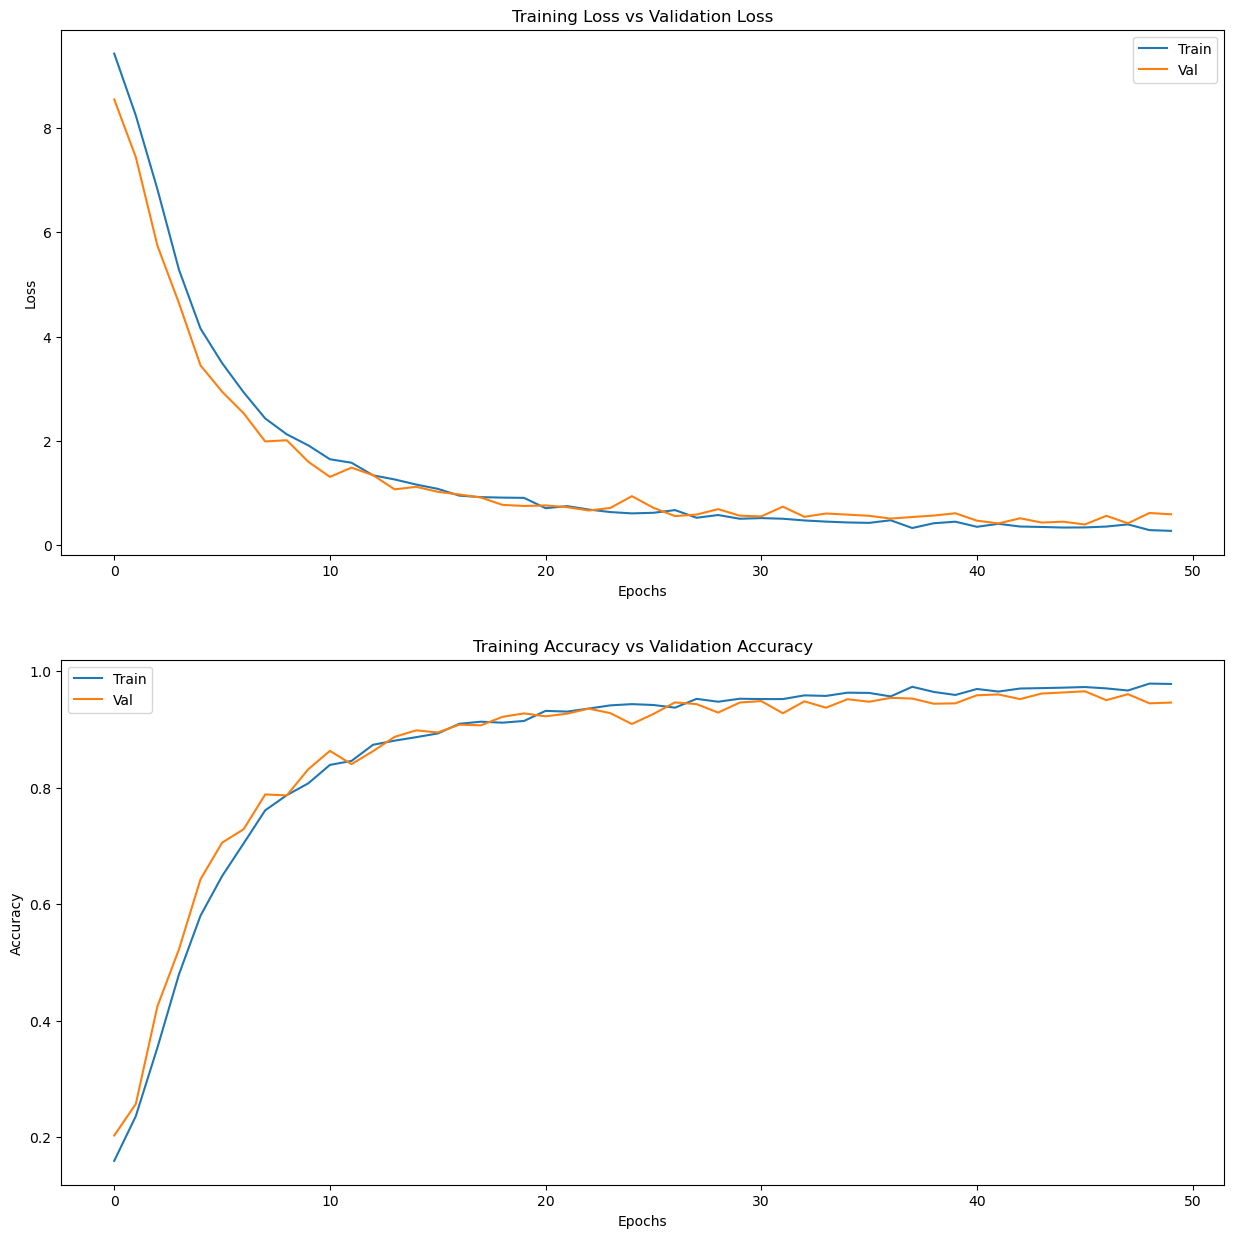

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(incep.history['loss'])
axs[0].plot(incep.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(incep.history['dense_4_accuracy'])
axs[1].plot(incep.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [14]:
pred = model.evaluate(test_set)

55/55 [==============================] - 57s 1s/step - loss: 0.6906 - dense_4_loss: 0.2254 - dense_1_loss: 0.2032 - dense_3_loss: 0.2620 - dense_4_accuracy: 0.9392 - dense_4_precision_m: 0.9465 - dense_4_recall_m: 0.9339 - dense_4_f1_m: 0.9401 - dense_1_accuracy: 0.9387 - dense_1_precision_m: 0.9465 - dense_1_recall_m: 0.9335 - dense_1_f1_m: 0.9399 - dense_3_accuracy: 0.9358 - dense_3_precision_m: 0.9432 - dense_3_recall_m: 0.9274 - dense_3_f1_m: 0.9351


In [15]:
model.save('model_clf.h5')

In [16]:
pred

[0.6906243562698364,
 0.22538495063781738,
 0.20324644446372986,
 0.2619929611682892,
 0.9392375946044922,
 0.9465349912643433,
 0.9338756799697876,
 0.940118670463562,
 0.9386643767356873,
 0.9464610815048218,
 0.9335399270057678,
 0.939912736415863,
 0.9357982277870178,
 0.9431610107421875,
 0.9273588061332703,
 0.9351378083229065]

## Prediction using saved Model

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# 
# y_pred = GoogLeNet_model.predict(test_generator)
# #y_pred =(y_pred > 0.5)
# #list(y_pred)
# #cm = confusion_matrix(test_ds, y_pred)
# print(y_pred)
# 


In [ ]:
# y_pred = np.argmax(y_pred, axis=0)
# print('Confusion Matrix')
# 
# print(confusion_matrix(training_set.classes, y_pred))
# print('Classification Report')
# 
# print(classification_report(training_set.classes, y_pred , target_names=target_names))
# #target_names = []
# #print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install tensorflowjs
# !tensorflowjs_converter --input_format keras "model_clf.h5" /content/drive/MyDrive/incp